Device: cuda
Training started...


 66%|██████▌   | 1970/3000 [10:45<05:37,  3.05it/s]

Stopped at epoch 1970 (no loss improvement for 500)
Training complete.


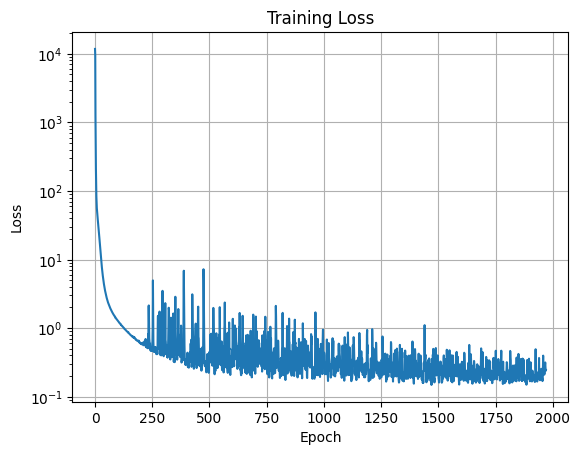

MSE Real: 2.73e-04, Imag: 2.73e-04


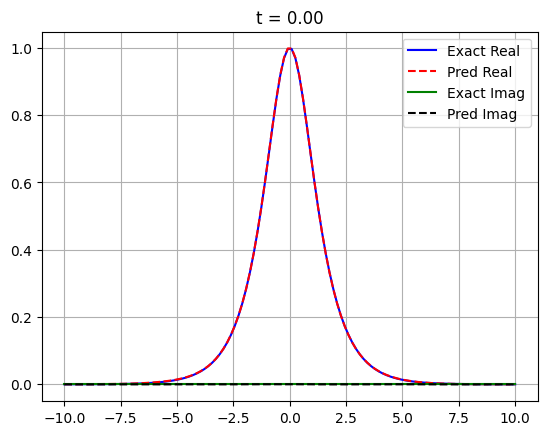

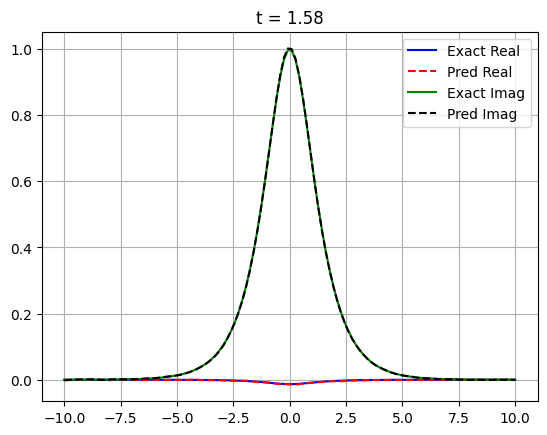

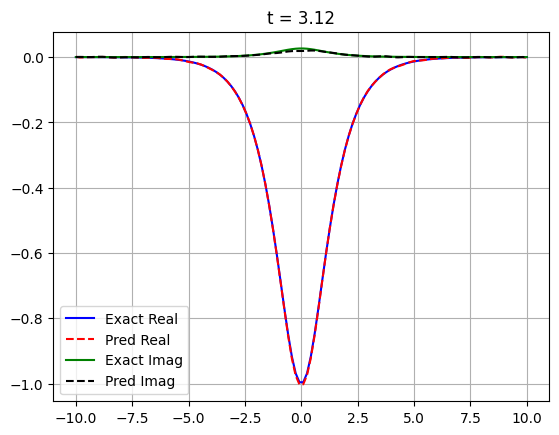

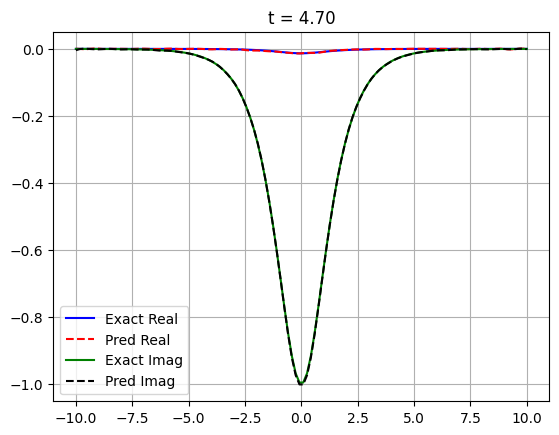

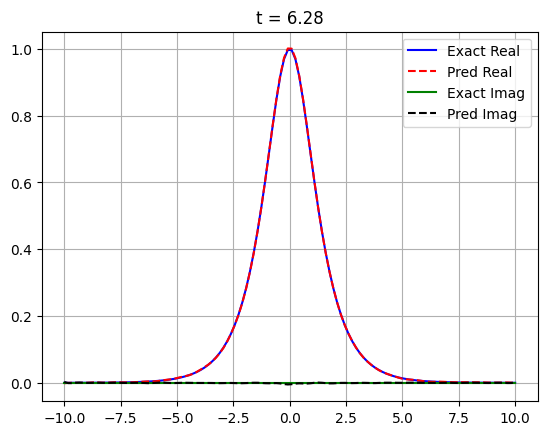

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from torch.amp import autocast, GradScaler
from tqdm import trange
import time

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = True

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Analytical solution for the Schrödinger equation
def exact_solution(x, t):
    u = 1 / np.cosh(x) * np.cos(t)
    v = 1 / np.cosh(x) * np.sin(t)
    return u, v

# Fourier Feature mapping layer
class FourierFeatureLayer(nn.Module):
    def __init__(self, in_dim, mapping_size=256, scale=5):
        super().__init__()
        self.register_buffer('B', torch.randn(in_dim, mapping_size // 2) * scale)

    def forward(self, x):
        x_proj = x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# PINN model
class PINN(nn.Module):
    def __init__(self, hidden_dim=128, fourier_features=256, fourier_scale=5):
        super().__init__()
        self.fourier = FourierFeatureLayer(2, fourier_features, fourier_scale)
        self.net = nn.Sequential(
            nn.Linear(fourier_features, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, 2)
        )
        self._init_weights()
        self.register_buffer('x_mean', torch.zeros(1))
        self.register_buffer('x_std', torch.ones(1))
        self.register_buffer('t_mean', torch.zeros(1))
        self.register_buffer('t_std', torch.ones(1))

    def _init_weights(self):
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def set_normalization(self, x_data, t_data):
        self.x_mean = torch.mean(x_data)
        self.x_std = torch.std(x_data) + 1e-8
        self.t_mean = torch.mean(t_data)
        self.t_std = torch.std(t_data) + 1e-8

    def forward(self, x, t):
        x_norm = (x - self.x_mean) / self.x_std
        t_norm = (t - self.t_mean) / self.t_std
        inputs = torch.cat([x_norm, t_norm], dim=1)
        features = self.fourier(inputs)
        return self.net(features)

# PDE residuals
def pde_residual(model, X):
    X.requires_grad_(True)
    x, t = X[:, :1], X[:, 1:2]
    u, v = model(x, t).split(1, dim=1)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    R1 = -v_t + 0.5 * u_xx + (u ** 2 + v ** 2) * u
    R2 = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    return R1, R2

# Spectral loss in frequency domain
def spectral_loss(pred, exact):
    pred = pred.view(-1, 2)
    exact = exact.view(-1, 2)
    pad = 2 ** int(np.ceil(np.log2(pred.shape[0]))) - pred.shape[0]
    pred_pad = torch.nn.functional.pad(pred, (0, 0, 0, pad))
    exact_pad = torch.nn.functional.pad(exact, (0, 0, 0, pad))
    pred_fft = torch.fft.rfft(pred_pad, dim=0)
    exact_fft = torch.fft.rfft(exact_pad, dim=0)
    return torch.mean((pred_fft - exact_fft).abs() ** 2)

# Point generation
def generate_points(x_range, t_range, n_col=30000):
    x = np.random.uniform(*x_range, n_col)
    t = np.random.uniform(*t_range, n_col)
    Xc = np.stack([x, t], axis=1)
    x_ic = np.linspace(*x_range, 1500)
    t_ic = np.zeros_like(x_ic)
    u_ic = 1 / np.cosh(x_ic)
    v_ic = np.zeros_like(x_ic)
    Xic = np.stack([x_ic, t_ic], axis=1)
    UV0 = np.stack([u_ic, v_ic], axis=1)
    return Xc, Xic, UV0

# Training function
def train(model, Xc, Xic, UV0, xr, tr, epochs=3000, bs=4096, w_pde=1.0, w_ic=10.0, lr=1e-3, wd=1e-6, patience=500):
    print("Training started...")
    model.to(device)
    Xc = torch.tensor(Xc, dtype=torch.float32).to(device)
    Xic = torch.tensor(Xic, dtype=torch.float32).to(device)
    UV0 = torch.tensor(UV0, dtype=torch.float32).to(device)
    x_all = torch.cat([Xc[:, 0:1], Xic[:, 0:1]])
    t_all = torch.cat([Xc[:, 1:2], Xic[:, 1:2]])
    model.set_normalization(x_all, t_all)

    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    mse = nn.MSELoss()
    scaler = GradScaler()

    best_loss = float('inf')
    best_model = None
    counter = 0
    history = []

    for epoch in trange(epochs):
        perm = torch.randperm(Xc.size(0))
        total_loss = 0.0

        for i in range(0, Xc.size(0), bs):
            idx = perm[i:i+bs]
            Xb = Xc[idx]
            opt.zero_grad()
            with autocast(device_type='cuda'):
                R1, R2 = pde_residual(model, Xb)
                lpde_u = mse(R1, torch.zeros_like(R1))
                lpde_v = mse(R2, torch.zeros_like(R2))
                lpde = 0.5 * (lpde_u + lpde_v)

                ic_pred = model(Xic[:, :1], Xic[:, 1:2])
                lic_u = mse(ic_pred[:, 0:1], UV0[:, 0:1])
                lic_v = mse(ic_pred[:, 1:2], UV0[:, 1:2])
                lic = 0.5 * (lic_u + lic_v)

                for tval in [np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 2*np.pi]:
                    xt = torch.linspace(*xr, 1000).view(-1, 1).to(device)
                    tt = torch.full_like(xt, tval)
                    up, vp = model(xt, tt).split(1, dim=1)
                    ue, ve = exact_solution(xt.cpu().numpy(), tval)
                    ue = torch.tensor(ue, dtype=torch.float32).to(device).view(-1, 1)
                    ve = torch.tensor(ve, dtype=torch.float32).to(device).view(-1, 1)
                    lic += mse(up, ue) + mse(vp, ve)

                lic += spectral_loss(ic_pred, UV0)
                reg = sum(torch.norm(p) for p in model.parameters())
                loss = w_pde * lpde + w_ic * lic + 1e-4 * reg

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            total_loss += loss.item()

        history.append(total_loss)
        if total_loss < best_loss:
            best_loss = total_loss
            best_model = {k: v.clone().detach().cpu() for k, v in model.state_dict().items()}
            counter = 0
        else:
            counter += 1

        if counter >= patience and epoch > epochs // 5:
            print(f"Stopped at epoch {epoch} (no loss improvement for {patience})")
            break

    model.load_state_dict(best_model)
    print("Training complete.")
    torch.save(model.state_dict(), 'final.pth')

    plt.plot(history)
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()

# Evaluation and visualization
def evaluate(model, x_range, t_range, res=100):
    x = np.linspace(*x_range, res)
    t = np.linspace(*t_range, res)
    X, T = np.meshgrid(x, t)
    u_exact, v_exact = exact_solution(X, T)
    Xf = torch.tensor(X.flatten()[:, None], dtype=torch.float32).to(device)
    Tf = torch.tensor(T.flatten()[:, None], dtype=torch.float32).to(device)

    with torch.no_grad():
        out = model(Xf, Tf)
    u_pred = out[:, 0].cpu().numpy().reshape(X.shape)
    v_pred = out[:, 1].cpu().numpy().reshape(X.shape)

    err_u = np.abs(u_pred - u_exact)
    err_v = np.abs(v_pred - v_exact)
    mse_u = np.mean(err_u ** 2)
    mse_v = np.mean(err_v ** 2)
    print(f"MSE Real: {mse_u:.2e}, Imag: {mse_v:.2e}")

    for ti in [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]:
        idx = np.abs(t - ti).argmin()
        plt.figure()
        plt.plot(x, u_exact[idx], 'b-', label='Exact Real')
        plt.plot(x, u_pred[idx], 'r--', label='Pred Real')
        plt.plot(x, v_exact[idx], 'g-', label='Exact Imag')
        plt.plot(x, v_pred[idx], 'k--', label='Pred Imag')
        plt.title(f't = {t[idx]:.2f}')
        plt.grid(True)
        plt.legend()
        plt.show()

    fig = go.Figure()
    fig.add_trace(go.Surface(z=u_exact, x=x, y=t, colorscale='Viridis', name='Exact Real'))
    fig.add_trace(go.Surface(z=u_pred, x=x, y=t, colorscale='Inferno', name='Pred Real'))
    fig.update_layout(title='Real part u(x,t)', scene=dict(zaxis_title='u'))
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Surface(z=v_exact, x=x, y=t, colorscale='Viridis', name='Exact Imag'))
    fig.add_trace(go.Surface(z=v_pred, x=x, y=t, colorscale='Inferno', name='Pred Imag'))
    fig.update_layout(title='Imaginary part v(x,t)', scene=dict(zaxis_title='v'))
    fig.show()

# Main

def main():
    xr = (-10, 10)
    tr = (0, 2*np.pi)
    model = PINN().to(device)
    Xc, Xic, UV0 = generate_points(xr, tr)
    train(model, Xc, Xic, UV0, xr, tr)
    evaluate(model, xr, tr, res=120)

if __name__ == '__main__':
    main()